# Causal ML, Uplift Modeling Part 1

## Import Libraries & Data

In [96]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklift.metrics import uplift_at_k,qini_auc_score
from sklift.datasets import fetch_hillstrom # our dataset!
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from sklearn.metrics import roc_auc_score, log_loss
from causalml.metrics import auuc_score
import seaborn as sns

In [48]:
# Load Hillstrom dataset
def load_hillstrom():
    dataset = fetch_hillstrom(target_col='visit')
    df = dataset.data
    # Segment has 3 options, womens email, mens email and no email, so we can create 'treatment' by choosing one of the two treatments here
    df['segment'] = dataset.treatment
    # There are 3 outcomes, visit, conversion and spend, we can choose one of them as our target
    df['visit'] = dataset.target
    print("Are there any null values in this dataframe?\n")
    print(df.isna().sum())
    print("\n\n\n")
    print("What does the dataframe look like? What datatypes are the features?\n")
    print(df.info())
    return df

df = load_hillstrom()

Are there any null values in this dataframe?

recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
segment            0
visit              0
dtype: int64




What does the dataframe look like? What datatypes are the features?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64

## Explore Data

In [27]:
# The treatment
df['segment'].value_counts()

segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64

In [28]:
# Let's just use men's email first and create a treatment variable to 1/0 the treatment/control
df = df.loc[df['segment'].isin(['Mens E-Mail','No E-Mail'])]
df['treatment'] = df['segment'].map({'Mens E-Mail':1,'No E-Mail':0})
df['treatment'].value_counts(normalize=True)

C:\Users\wallj\AppData\Local\Temp\ipykernel_20352\4275732468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['treatment'] = df['segment'].map({'Mens E-Mail':1,'No E-Mail':0})


treatment
1    0.500012
0    0.499988
Name: proportion, dtype: float64

In [29]:
# This dataset has visit, conversion, and revenue as the target variables, we are going to use visit as the target variable
df['target'] = df['visit'].copy()
df['target'].value_counts()

C:\Users\wallj\AppData\Local\Temp\ipykernel_20352\4058060974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['visit'].copy()


target
0    36457
1     6156
Name: count, dtype: int64

In [30]:
# Customer purchased mens merchandise in the past year
df['mens'].value_counts()

mens
1    23526
0    19087
Name: count, dtype: int64

In [31]:
# Customer purchased womens merchandise in the past year
df['womens'].value_counts()

womens
1    23417
0    19196
Name: count, dtype: int64

In [32]:
# Only a few customers purchased from both mens and womens merch in the past year
df.groupby(['mens','womens']).size()

mens  womens
0     1         19087
1     0         19196
      1          4330
dtype: int64

In [33]:
# segments for TTM spend
df['history_segment'].value_counts()

history_segment
1) $0 - $100        15336
2) $100 - $200       9527
3) $200 - $350       8134
4) $350 - $500       4221
5) $500 - $750       3249
6) $750 - $1,000     1266
7) $1,000 +           880
Name: count, dtype: int64

In [34]:
# Actual TTM spend
df['history'].describe()

count    42613.000000
mean       241.859315
std        256.574723
min         29.990000
25%         64.500000
50%        157.000000
75%        325.210000
max       3345.930000
Name: history, dtype: float64

In [35]:
# Months since last purchase
df['recency'].value_counts()

recency
1     5934
2     5074
10    5022
9     4330
3     3899
4     3406
6     3048
5     2985
7     2720
8     2337
11    2316
12    1542
Name: count, dtype: int64

In [36]:
# New custome in past year
df['newbie'].value_counts()

newbie
1    21381
0    21232
Name: count, dtype: int64

In [37]:
# TTM purchase channels - must be an old dataset given the phone count
df['channel'].value_counts()

channel
Web             18863
Phone           18567
Multichannel     5183
Name: count, dtype: int64

In [38]:
# Classifies urban rural and suburban
df['zip_code'].value_counts()

zip_code
Surburban    19126
Urban        17105
Rural         6382
Name: count, dtype: int64

In [39]:
# Binarize the zip code and channel variables
df = pd.get_dummies(df, columns=['zip_code'], drop_first=True, dtype=int)  # Encode categorical variable
df = pd.get_dummies(df, columns=['channel'], drop_first=True, dtype=int)  # Encode categorical variable
df = df.drop(columns=['history_segment','segment','visit']) # Drop unnecessary features

In [40]:
# One grand view of our final dataset! Looks ready for modeling.
df.head()

,recency,history,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
1,6,329.08,1,1,1,0,0,0,0,0,1
3,9,675.83,1,0,1,1,0,0,0,0,1
8,9,675.07,1,1,1,1,0,0,0,1,0
13,2,101.64,0,1,0,1,1,0,1,0,1
14,4,241.42,0,1,1,0,0,0,0,0,0


In [41]:
# It appears everything is just about equal in terms of the treatment group and the control group for feature means, except the target which is ok
df.groupby('treatment').mean()

# Even if it wasn't, we could still run the model using the covariates as features, but would need to adjust for the imbalance in the treatment groups

,recency,history,mens,womens,newbie,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
treatment,,,,,,,,,,
0,5.749695,240.882653,0.553224,0.547639,0.501971,0.106167,0.451751,0.400920,0.437764,0.439923
1,5.773642,242.835931,0.550946,0.551415,0.501525,0.182757,0.445910,0.401887,0.433660,0.445394


## Split Train Test Treatment

In [18]:
# Split data into train/test
def split_data(df):
    X = df.drop(columns=['treatment', 'target'])
    y = df['target']
    treatment = df['treatment']
    return train_test_split(X, y, treatment, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test, t_train, t_test = split_data(df)

## Run Two-Model and Single-Model Approaches

In [19]:
# Model Optimization with Optuna
def optimize_model(trial, X, y, model_type):
    # Set the hyperparameters to optimize and the ranges for xgboost
    if model_type == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
        }
        model = XGBClassifier(**params, eval_metric='logloss')
        # Even though the eval metric for xgboost is logloss, we are evaluating the hyperparameters on maximizing AUC
    # Set the hyperparameters to optimize the ranges for random forest
    elif model_type == 'random_forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
        }
        model = RandomForestClassifier(**params, random_state=42)
    else:
        raise ValueError("Unsupported model type")

    scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
    return np.mean(scores)

In [20]:
# Run Optuna for Both Models
def run_optuna(X, y, model_type, model_seg, n_trials=50):
    # Create a study object to maximize the AUC
    study = optuna.create_study(direction='maximize')
    # optimize the study based on the input parameters
    study.optimize(lambda trial: optimize_model(trial, X, y, model_type), n_trials=n_trials)
    print(f"Best parameters for {model_type} for {model_seg}: {study.best_params}")
    return study.best_params

In [21]:
# Train and Evaluate Models
def train_and_evaluate(X_train, X_test, y_train, y_test, params, model_type, model_seg):
    # We'll look at xgboost and random forest, this is to train the final mdoel after optuna works it's magic
    if model_type == 'xgboost':
        model = XGBClassifier(**params,  eval_metric='logloss')
    elif model_type == 'random_forest':
        model = RandomForestClassifier(**params, random_state=42)
    else:
        raise ValueError("Unsupported model type")

    # Fit the model and predict probabilities on the test dataset
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    # Grab the AUC & LogLoss metrics for the best model
    auc = roc_auc_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    print(f"{model_type} AUC for {model_seg}: {auc:.4f}\n{model_type} Log Loss for {model_seg}: {logloss:.4f}")
    return model,y_pred

In [22]:
# Optimize and Train Separate Models for Two-Model Approach
def two_model_approach_with_optuna(X_train, X_test, y_train, y_test, t_train):
    
    # Use function run_optuna to optimize the treatment model for xgboost and random forest adn return the optimal hyperparameters

    # Optimize treatment model for xgboost and random forest
    X_treatment = X_train[t_train == 1]
    y_treatment = y_train[t_train == 1]
    params_treatment_xgboost = run_optuna(X_treatment, y_treatment, 'xgboost','treatment')
    params_treatment_randomforest = run_optuna(X_treatment, y_treatment, 'random_forest','treatment')

    # Optimize control model for xgboost and random forest
    X_control = X_train[t_train == 0]
    y_control = y_train[t_train == 0]
    params_control_xgboost = run_optuna(X_control, y_control, 'xgboost','control')
    params_control_randomforest = run_optuna(X_control, y_control, 'random_forest','control')


    # Optimize single model for xgboost and random forest
    X_single_train = X_train.copy()
    X_single_train['treatment'] = t_train
    X_single_test_1 = X_test.copy()
    X_single_test_1['treatment'] = 1
    X_single_test_0 = X_test.copy()
    X_single_test_0['treatment'] = 0
    params_single_xgboost = run_optuna(X_single_train, y_train, 'xgboost','single')
    params_single_randomforest = run_optuna(X_single_train, y_train, 'random_forest','single')

    # Train final models using function train_and_evaluate
    model_treatment_xgboost,preds_treatment_xgboost = train_and_evaluate(X_treatment, X_test, y_treatment, y_test, params_treatment_xgboost, 'xgboost','treatment')
    model_treatment_randomforest,preds_treatment_randomforest = train_and_evaluate(X_treatment, X_test, y_treatment, y_test, params_treatment_randomforest, 'random_forest','treatment')
    model_control_xgboost,preds_control_xgboost = train_and_evaluate(X_control, X_test, y_control, y_test, params_control_xgboost, 'xgboost','control')
    model_control_randomforest,preds_control_randomforest = train_and_evaluate(X_control, X_test, y_control, y_test, params_control_randomforest, 'random_forest','control')
    model_single_1_xgboost,preds_single_1_xgboost = train_and_evaluate(X_single_train, X_single_test_1, y_train, y_test, params_single_xgboost, 'xgboost','single_1')
    model_single_1_randomforest,preds_single_1_randomforest = train_and_evaluate(X_single_train, X_single_test_1, y_train, y_test, params_single_randomforest, 'random_forest','single_1')
    model_single_0_xgboost,preds_single_0_xgboost = train_and_evaluate(X_single_train, X_single_test_0, y_train, y_test, params_single_xgboost, 'xgboost','single_0')
    model_single_0_randomforest,preds_single_0_randomforest = train_and_evaluate(X_single_train, X_single_test_0, y_train, y_test, params_single_randomforest, 'random_forest','single_0')

    return model_treatment_xgboost, preds_treatment_xgboost, model_treatment_randomforest, preds_treatment_randomforest, model_control_xgboost, preds_control_xgboost, model_control_randomforest, preds_control_randomforest, model_single_1_xgboost, preds_single_1_xgboost, model_single_1_randomforest, preds_single_1_randomforest, model_single_0_xgboost, preds_single_0_xgboost, model_single_0_randomforest, preds_single_0_randomforest

In [23]:
%%time
# Execute the Two-Model Approach with Optuna usng function "two_model_approach_with_optuna"
model_treatment_xgboost, preds_treatment_xgboost, model_treatment_randomforest, preds_treatment_randomforest, model_control_xgboost, preds_control_xgboost, model_control_randomforest, preds_control_randomforest, model_single_1_xgboost, preds_single_1_xgboost, model_single_1_randomforest, preds_single_1_randomforest, model_single_0_xgboost, preds_single_0_xgboost, model_single_0_randomforest, preds_single_0_randomforest = two_model_approach_with_optuna(X_train, X_test, y_train, y_test, t_train)

[I 2024-12-24 09:49:53,105] A new study created in memory with name: no-name-3da02411-6c0c-48d6-9772-de3bac973c6a
[I 2024-12-24 09:49:54,933] Trial 0 finished with value: 0.594201554964171 and parameters: {'n_estimators': 264, 'max_depth': 8, 'learning_rate': 0.03697948243256558, 'subsample': 0.9789366472121683, 'colsample_bytree': 0.8925859732662579, 'gamma': 0.9960341155890934}. Best is trial 0 with value: 0.594201554964171.
[I 2024-12-24 09:49:55,490] Trial 1 finished with value: 0.6094026652248743 and parameters: {'n_estimators': 294, 'max_depth': 7, 'learning_rate': 0.012761950197697354, 'subsample': 0.611201673202611, 'colsample_bytree': 0.7840885259437869, 'gamma': 2.6155174639646113}. Best is trial 1 with value: 0.6094026652248743.
[I 2024-12-24 09:49:55,860] Trial 2 finished with value: 0.610211190645689 and parameters: {'n_estimators': 287, 'max_depth': 7, 'learning_rate': 0.05181016737301728, 'subsample': 0.928948336148546, 'colsample_bytree': 0.653765217614288, 'gamma': 2.0

Best parameters for xgboost for treatment: {'n_estimators': 102, 'max_depth': 3, 'learning_rate': 0.11632761668007933, 'subsample': 0.6751078118477671, 'colsample_bytree': 0.7776967736850459, 'gamma': 4.193819592426093}


[I 2024-12-24 09:50:12,753] Trial 0 finished with value: 0.584891936257766 and parameters: {'n_estimators': 156, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.62089010459249}. Best is trial 0 with value: 0.584891936257766.
[I 2024-12-24 09:50:17,485] Trial 1 finished with value: 0.6016595279434975 and parameters: {'n_estimators': 222, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 0.80667848323974}. Best is trial 1 with value: 0.6016595279434975.
[I 2024-12-24 09:50:20,102] Trial 2 finished with value: 0.5711765558855797 and parameters: {'n_estimators': 103, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.6322732671788945}. Best is trial 1 with value: 0.6016595279434975.
[I 2024-12-24 09:50:23,442] Trial 3 finished with value: 0.5776275132633549 and parameters: {'n_estimators': 121, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 0.7244572591856215}. Bes

Best parameters for random_forest for treatment: {'n_estimators': 287, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 0.8202342719244073}


[I 2024-12-24 09:54:30,872] Trial 0 finished with value: 0.639495720152966 and parameters: {'n_estimators': 187, 'max_depth': 6, 'learning_rate': 0.15566463557574328, 'subsample': 0.6555569593275864, 'colsample_bytree': 0.6404033940936004, 'gamma': 3.0849459596189144}. Best is trial 0 with value: 0.639495720152966.
[I 2024-12-24 09:54:31,113] Trial 1 finished with value: 0.6368092835329298 and parameters: {'n_estimators': 119, 'max_depth': 3, 'learning_rate': 0.01166236837676965, 'subsample': 0.7586037738522498, 'colsample_bytree': 0.8355367806961506, 'gamma': 1.3091014645582533}. Best is trial 0 with value: 0.639495720152966.
[I 2024-12-24 09:54:31,256] Trial 2 finished with value: 0.6376679933917501 and parameters: {'n_estimators': 80, 'max_depth': 9, 'learning_rate': 0.08231549604763208, 'subsample': 0.8729226599870019, 'colsample_bytree': 0.9019849671552973, 'gamma': 4.699247444300834}. Best is trial 0 with value: 0.639495720152966.
[I 2024-12-24 09:54:31,763] Trial 3 finished with

Best parameters for xgboost for control: {'n_estimators': 228, 'max_depth': 9, 'learning_rate': 0.05043301607546585, 'subsample': 0.6655839492292278, 'colsample_bytree': 0.8437921881216988, 'gamma': 4.747164143894018}


[I 2024-12-24 09:54:51,182] Trial 0 finished with value: 0.6058962813485692 and parameters: {'n_estimators': 94, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 0.6707982896638695}. Best is trial 0 with value: 0.6058962813485692.
[I 2024-12-24 09:55:02,271] Trial 1 finished with value: 0.6133905983300587 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 0.9319383592942475}. Best is trial 1 with value: 0.6133905983300587.
[I 2024-12-24 09:55:08,269] Trial 2 finished with value: 0.6139776035554881 and parameters: {'n_estimators': 228, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 0.6174749231880458}. Best is trial 2 with value: 0.6139776035554881.
[I 2024-12-24 09:55:17,541] Trial 3 finished with value: 0.6094723286922801 and parameters: {'n_estimators': 278, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.80149802593437

Best parameters for random_forest for control: {'n_estimators': 101, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 0.7080358232261376}


[I 2024-12-24 09:57:27,089] Trial 0 finished with value: 0.6467908442969926 and parameters: {'n_estimators': 291, 'max_depth': 6, 'learning_rate': 0.023074735318433903, 'subsample': 0.8154140786461395, 'colsample_bytree': 0.8492148260692909, 'gamma': 0.936052195326052}. Best is trial 0 with value: 0.6467908442969926.
[I 2024-12-24 09:57:27,875] Trial 1 finished with value: 0.6533685375907492 and parameters: {'n_estimators': 295, 'max_depth': 6, 'learning_rate': 0.012083113970563157, 'subsample': 0.8805581225811496, 'colsample_bytree': 0.6466884287843676, 'gamma': 2.6044487801446916}. Best is trial 1 with value: 0.6533685375907492.
[I 2024-12-24 09:57:28,341] Trial 2 finished with value: 0.6548033500570012 and parameters: {'n_estimators': 235, 'max_depth': 7, 'learning_rate': 0.04421264367220951, 'subsample': 0.7970940667673752, 'colsample_bytree': 0.6559513576096782, 'gamma': 3.001826506057709}. Best is trial 2 with value: 0.6548033500570012.
[I 2024-12-24 09:57:28,635] Trial 3 finishe

Best parameters for xgboost for single: {'n_estimators': 237, 'max_depth': 3, 'learning_rate': 0.18386627321446009, 'subsample': 0.7641892540586966, 'colsample_bytree': 0.6668181529859585, 'gamma': 3.4690351298438658}


[I 2024-12-24 09:57:55,184] Trial 0 finished with value: 0.6446969800265528 and parameters: {'n_estimators': 146, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 0.7265457161643938}. Best is trial 0 with value: 0.6446969800265528.
[I 2024-12-24 09:58:10,397] Trial 1 finished with value: 0.6384435140425985 and parameters: {'n_estimators': 298, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.6684689226884111}. Best is trial 0 with value: 0.6446969800265528.
[I 2024-12-24 09:58:22,512] Trial 2 finished with value: 0.6210124464574959 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 0.6962432886213047}. Best is trial 0 with value: 0.6446969800265528.
[I 2024-12-24 09:58:31,445] Trial 3 finished with value: 0.6369145704307216 and parameters: {'n_estimators': 293, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.900279001127513}.

Best parameters for random_forest for single: {'n_estimators': 71, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 0.6839645101285281}
xgboost AUC for treatment: 0.6215
xgboost Log Loss for treatment: 0.4092
random_forest AUC for treatment: 0.6183
random_forest Log Loss for treatment: 0.4099
xgboost AUC for control: 0.6207
xgboost Log Loss for control: 0.4140
random_forest AUC for control: 0.6153
random_forest Log Loss for control: 0.4166
xgboost AUC for single_1: 0.6253
xgboost Log Loss for single_1: 0.4087
random_forest AUC for single_1: 0.6180
random_forest Log Loss for single_1: 0.4101
xgboost AUC for single_0: 0.6216
xgboost Log Loss for single_0: 0.4134
random_forest AUC for single_0: 0.6148
random_forest Log Loss for single_0: 0.4160
CPU times: total: 27min 6s
Wall time: 14min 47s


In [24]:
# Uplift scores
def create_uplift_scores(preds_treatment_xgboost,
                        preds_control_xgboost,
                        preds_treatment_randomforest,
                        preds_control_randomforest,
                        preds_single_1_xgboost,
                        preds_single_1_randomforest,
                        preds_single_0_xgboost,
                        preds_single_0_randomforest):

    uplift_two_model_rf = preds_treatment_randomforest - preds_control_randomforest

    uplift_two_model_xg = preds_treatment_xgboost - preds_control_xgboost

    uplift_single_model_xg = preds_single_1_xgboost - preds_single_0_xgboost
    
    uplift_single_model_rf = preds_single_1_randomforest - preds_single_0_randomforest
    
    return uplift_two_model_rf, uplift_two_model_xg, uplift_single_model_xg, uplift_single_model_rf

uplift_two_model_rf, uplift_two_model_xg, uplift_single_model_xg, uplift_single_model_rf = create_uplift_scores(preds_treatment_xgboost,
                                                                                                                preds_control_xgboost,
                                                                                                                preds_treatment_randomforest,
                                                                                                                preds_control_randomforest,
                                                                                                                preds_single_1_xgboost,
                                                                                                                preds_single_1_randomforest,
                                                                                                                preds_single_0_xgboost,
                                                                                                                preds_single_0_randomforest
                                                                                                                )

## Compare Two-Model Approaches and Single-Model Approaches

### sklift Qini AUC Score

In [49]:
# Let's try sklift's qini auc score
qini_two_model_rf = qini_auc_score(y_test, uplift_two_model_rf, t_test)
qini_two_model_xg = qini_auc_score(y_test, uplift_two_model_xg, t_test)
qini_single_model_rf = qini_auc_score(y_test, uplift_single_model_rf, t_test)
qini_single_model_xg = qini_auc_score(y_test, uplift_single_model_xg, t_test)

comparison_df = pd.DataFrame({
    'Model': ['Two-Model RF', 'Two-Model XG', 'Single-Model RF', 'Single-Model XG'],
    'Qini Score': [qini_two_model_rf, qini_two_model_xg, qini_single_model_rf, qini_single_model_xg]
})
print("\n### Qini Score Comparison ###")
print(comparison_df)

# We can see initially that the XG, despite outperforming the RF on the individual models by a bit, does not outperform the random forest in the uplift model scenario
# The Two-Model RF beats out the single model RF by a little bit as well. Let's continue on.


### Qini Score Comparison ###
             Model  Qini Score
0     Two-Model RF    0.019583
1     Two-Model XG    0.009820
2  Single-Model RF    0.019218
3  Single-Model XG    0.015047


### Manual Qini Score

In [50]:
# Let's now try a manual calculation of the Qini Score
def calculate_uplift_metrics(df,uplift, n_groups=5):
    """
    Calculate common uplift model evaluation metrics.
    
    Parameters:
    y_true: array-like, actual outcome (visits)
    treatment: array-like, treatment indicator (0/1)
    uplift_scores: array-like, predicted uplift scores
    n_groups: int, number of groups for AUUC calculation
    
    Returns:
    dict with uplift metrics
    """
    # Sort by uplift scores
    df = df.sort_values(by=uplift, ascending=False)
    y_true = df['y_true'].values
    treatment = df['treatment'].values
    
    # Calculate cumulative gains
    n_samples = len(y_true)
    group_size = n_samples // n_groups
    
    gains = []
    for i in range(n_groups):
        start_idx = i * group_size
        end_idx = (i + 1) * group_size if i < n_groups - 1 else n_samples
        
        group_treat = treatment[start_idx:end_idx]
        group_outcome = y_true[start_idx:end_idx]
        
        # Calculate treatment and control response rates
        treat_rate = np.mean(group_outcome[group_treat == 1])
        ctrl_rate = np.mean(group_outcome[group_treat == 0])
        
        # Calculate uplift
        uplift = treat_rate - ctrl_rate
        gains.append(uplift)
    
    # Calculate metrics
    metrics = {
        'AUUC': np.trapz(gains) / len(gains),  # Area Under the Uplift Curve
        'Qini': np.sum(gains),  # Qini coefficient
        'top_group_uplift': gains[0],  # Uplift in highest scored group
        'uplift_by_group': gains
    }
    
    return metrics

In [71]:
# Create a dataframe with test results
results_df = pd.DataFrame({
    'y_true': y_test,               # Actual outcomes
    'treatment': t_test,            # Treatment indicators
    'uplift_tm_rf': uplift_two_model_rf,         # Uplift predictions from Random Forest
    'uplift_tm_xg': uplift_two_model_xg,        # Uplift predictions from XGBoost
    'uplift_sm_rf' : uplift_single_model_rf,
    'uplift_sm_xg' : uplift_single_model_xg
})
results_df.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg
493,0,0,0.078133,0.084332,0.086003,0.093250
21569,0,1,0.046404,0.049315,0.047965,0.062254
3531,0,0,0.082047,0.090028,0.109094,0.063480
50370,1,1,0.056380,0.098193,0.060075,0.079123
38375,0,1,0.105107,0.093774,0.065867,0.208003


In [58]:
xg_tm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_tm_xg'
   )

rf_tm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_tm_rf'
   )

xg_sm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_sm_xg'
   )

rf_sm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_sm_rf'
   )

In [62]:
print(rf_tm_metrics)
print(xg_tm_metrics)
print(rf_sm_metrics)
print(xg_sm_metrics)
# So here we are seeing the qini scores much higher and more similar.
# The XGBoost models win in this scenario
# For the AUUC, the RF wins for the TM but the XG wins for the SM

{'AUUC': 0.055813282759623696, 'Qini': 0.3684180832920917, 'top_group_uplift': 0.10781466685034671, 'uplift_by_group': [0.10781466685034671, 0.05518571586024469, 0.06543209876543209, 0.06909692967846857, 0.0708886721375996]}
{'AUUC': 0.0534942393093916, 'Qini': 0.3688020017568995, 'top_group_uplift': 0.10947781550113728, 'uplift_by_group': [0.10947781550113728, 0.05880699820911971, 0.05659557383530449, 0.0507378192925923, 0.09318379491874569]}
{'AUUC': 0.05454698103451481, 'Qini': 0.3648979634344608, 'top_group_uplift': 0.10336674914990823, 'uplift_by_group': [0.10336674914990823, 0.06329613812738209, 0.07554858934169278, 0.04172711944161242, 0.08095936737386522]}
{'AUUC': 0.05738932052525234, 'Qini': 0.3685485320329818, 'top_group_uplift': 0.1030154633489952, 'uplift_by_group': [0.1030154633489952, 0.04754638791465016, 0.07720442286583104, 0.08059386243906033, 0.06018839546444512]}


### CausalML AUUC Score

In [91]:
auuc_calc = auuc_score(
        df=results_df,
        outcome_col="y_true",
        treatment_col="treatment",
        treatment_effect_col=None
    )
print(auuc_calc)
# Boy this a bummer, looks like the RF win in this case with the two model RF coming in first, but not much better than random, yikes.

uplift_tm_rf    0.532856
uplift_tm_xg    0.518863
uplift_sm_rf    0.532925
uplift_sm_xg    0.526695
Random          0.514123
dtype: float64


### Decile Chart?

In [108]:
results_df = results_df.sort_values(by='uplift_tm_rf', ascending=False)

In [109]:
results_df['decile_tm_rf'] = pd.qcut(results_df['uplift_tm_rf'], 10, labels=False, duplicates='drop', ) + 1


In [111]:
def calculate_uplift(df):
    treated = df[df['treatment'] == 1]['y_true'].mean()
    control = df[df['treatment'] == 0]['y_true'].mean()
    return treated - control

# Group by decile and calculate observed uplift
decile_uplift = results_df.groupby('decile_tm_rf').apply(calculate_uplift).reset_index(name='observed_uplift_tm_rf')

C:\Users\wallj\AppData\Local\Temp\ipykernel_20352\3131367042.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decile_uplift = results_df.groupby('decile_tm_rf').apply(calculate_uplift).reset_index(name='observed_uplift_tm_rf')


C:\Users\wallj\AppData\Local\Temp\ipykernel_20352\1261464934.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='decile_tm_rf', y='observed_uplift_tm_rf', data=decile_uplift, palette='Blues_d')


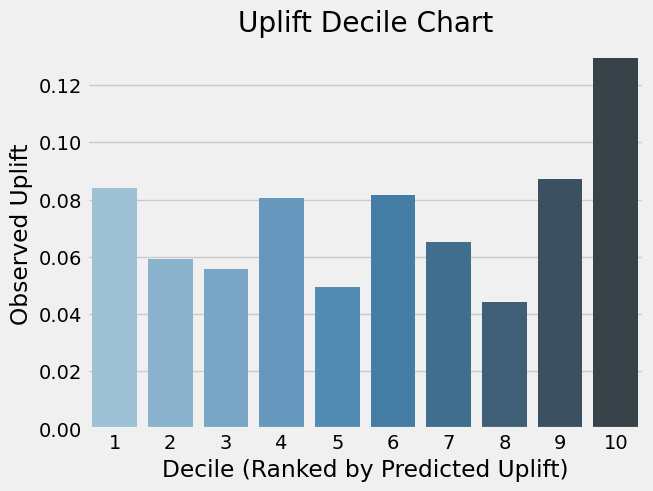

In [112]:
# Plot the observed uplift by decile
sns.barplot(x='decile_tm_rf', y='observed_uplift_tm_rf', data=decile_uplift, palette='Blues_d')
plt.title('Uplift Decile Chart')
plt.xlabel('Decile (Ranked by Predicted Uplift)')
plt.ylabel('Observed Uplift')
plt.show()

This is terrible

### Fake Qini Curve

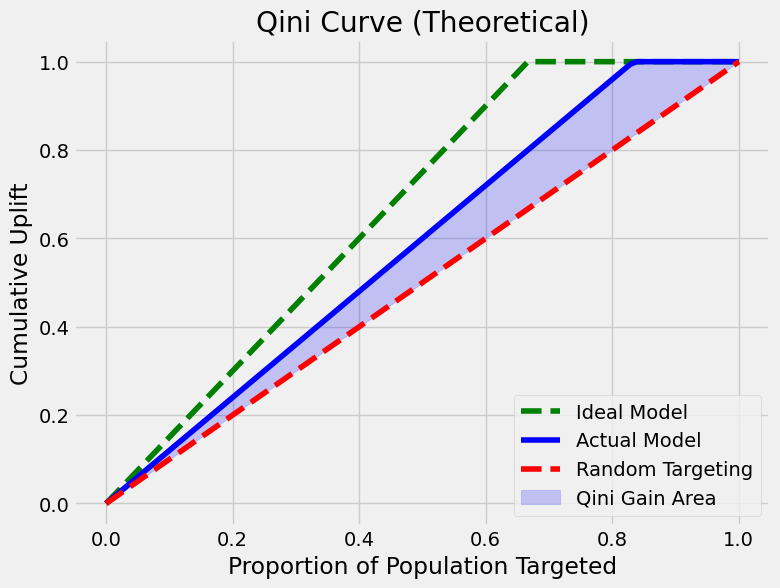

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Create data for a Qini curve
population_targeted = np.linspace(0, 1, 100)  # Proportion of population targeted (X-axis)
random_gain = population_targeted  # Baseline (random targeting)
ideal_gain = np.minimum(population_targeted * 1.5, 1.0)  # Ideal model (optimistic upper bound)
model_gain = np.minimum(population_targeted * 1.2, 1.0)  # Typical uplift model

# Plot the Qini curve
plt.figure(figsize=(8, 6))
plt.plot(population_targeted, ideal_gain, label="Ideal Model", linestyle="--", color="green")
plt.plot(population_targeted, model_gain, label="Actual Model", color="blue")
plt.plot(population_targeted, random_gain, label="Random Targeting", linestyle="--", color="red")
plt.fill_between(population_targeted, random_gain, model_gain, color="blue", alpha=0.2, label="Qini Gain Area")

# Customize plot
plt.title("Qini Curve (Theoretical)")
plt.xlabel("Proportion of Population Targeted")
plt.ylabel("Cumulative Uplift")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
